# **Modeling and Evaluation**

## Objectives

* Answer business requirement 2:
    * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.


## Inputs

* inputs/cherryleaves_dataset/cherry-leaves/train
* inputs/cherryleaves_dataset/cherry-leaves/test
* inputs/cherryleaves_dataset/cherry-leaves/validation
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

---

# Import necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib.image import imread

---

# Set working directory

Change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
cwd = os.getcwd()

In [3]:
os.chdir('/workspaces/mildew_detection')
print("Changed working directory to:", os.getcwd())

Changed working directory to: /workspaces/mildew_detection


Get the current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew_detection'

* #### Set input directories

In [5]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
validation_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

* #### Set output directories

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

* #### Check if previous version is available

In [7]:
if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available, Create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available, Create a new version.


* #### Set label

In [8]:
labels = os.listdir(train_path)
print('Label for the images are',labels)

Label for the images are ['powdery_mildew', 'healthy']


* #### Load image shape

In [9]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Number of images in train, test and validation data

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images




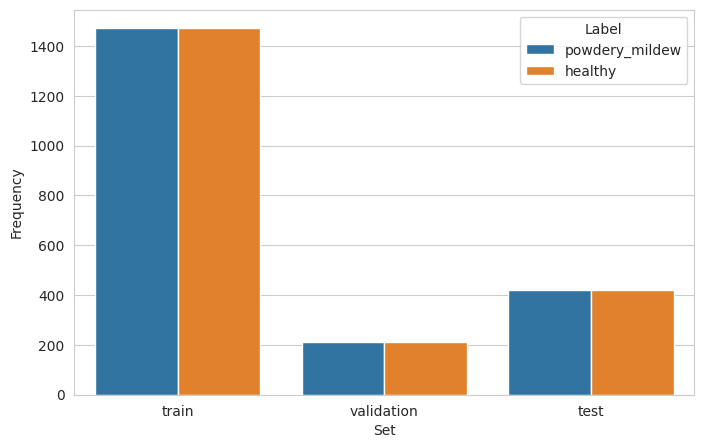

In [10]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

* #### Check distribution of sets

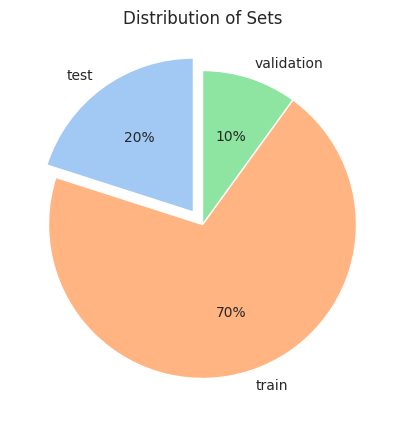

In [11]:
df_set_distribution = df_freq.groupby('Set')['Frequency'].sum().reset_index()

# Create a pie chart for the distribution of sets
plt.figure(figsize=(8, 5))
plt.pie(df_set_distribution['Frequency'], labels=df_set_distribution['Set'], autopct='%1.0f%%', startangle=90,
        colors=sns.color_palette('pastel'), explode=(0.1, 0, 0))  # Adjust explode for emphasis
plt.title('Distribution of Sets')
plt.savefig(f'{file_path}/sets_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

* #### Image Data Generator

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* #### Initialize ImageDataGenerator

In [13]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

* #### Augment training image dataset

In [14]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* #### Plot augment training image

(20, 256, 256, 3)


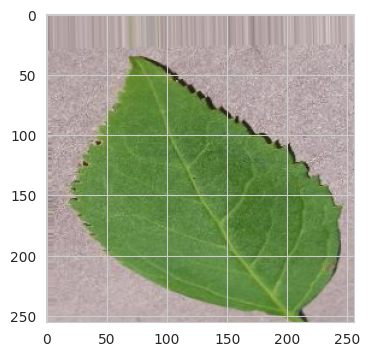

(20, 256, 256, 3)


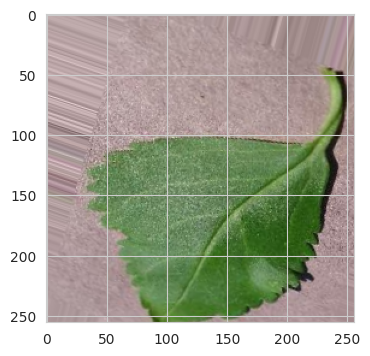

(20, 256, 256, 3)


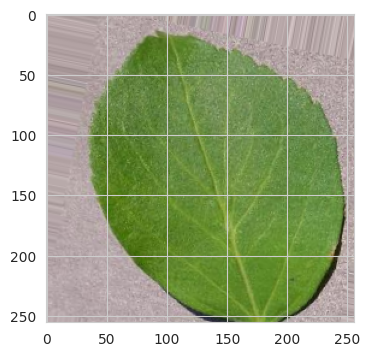

In [15]:
for _ in range(3):
    plt.figure(figsize=(4, 4))
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

* #### Augment validation image dataset

In [16]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* #### Plot augment validation images

(20, 256, 256, 3)


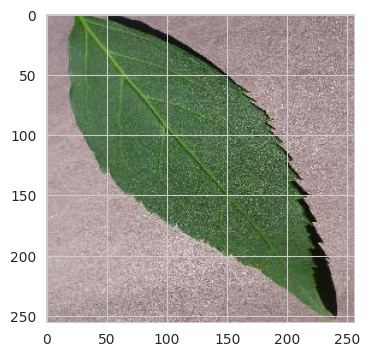

(20, 256, 256, 3)


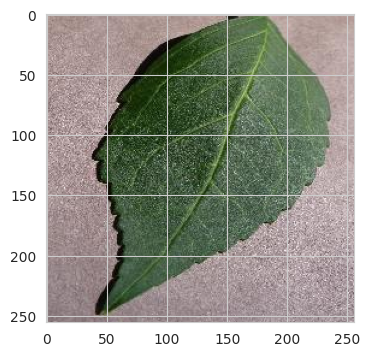

(20, 256, 256, 3)


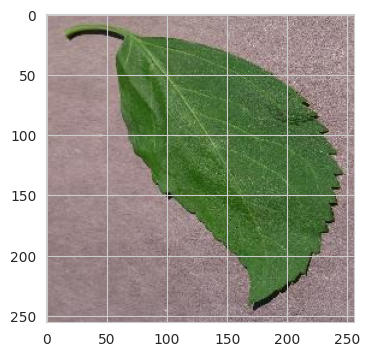

In [17]:
for _ in range(3):
    plt.figure(figsize=(4, 4))
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

* #### Augment test image dataset

In [18]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* #### Plot augmented test image

(20, 256, 256, 3)


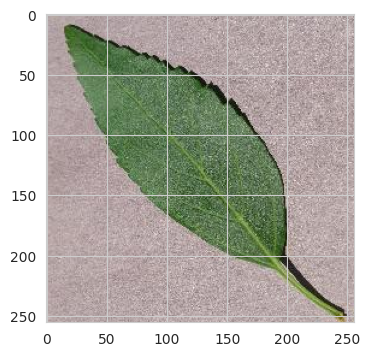

(20, 256, 256, 3)


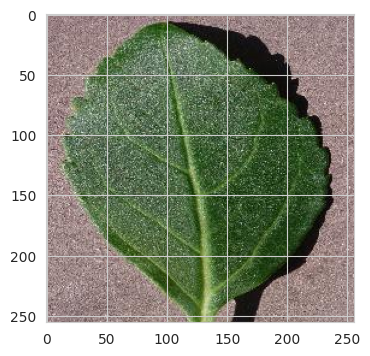

(20, 256, 256, 3)


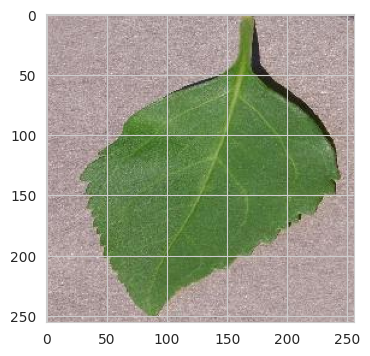

In [19]:
for _ in range(3):
    plt.figure(figsize=(4, 4))
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

---

# Model Creation

* #### Import model packages

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

* #### Model

In [25]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

* #### Model Summary

In [26]:
create_tf_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)            

* #### Early Stopping

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

* #### Fit model for training

In [28]:
model = create_tf_model()
model.fit(train_set,
          epochs=20,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2023-11-20 21:13:29.281829: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
147/147 [==============================] - 232s 2s/step - loss: 0.3992 - accuracy: 0.7927 - val_loss: 0.0719 - val_accuracy: 0.9714
Epoch 2/20
147/147 [==============================] - 230s 2s/step - loss: 0.1376 - accuracy: 0.9600 - val_loss: 0.0415 - val_accuracy: 0.9857
Epoch 3/20
147/147 [==============================] - 230s 2s/step - loss: 0.0627 - accuracy: 0.9819 - val_loss: 0.0222 - val_accuracy: 0.9905
Epoch 4/20
147/147 [==============================] - 229s 2s/step - loss: 0.0506 - accuracy: 0.9887 - val_loss: 0.0222 - val_accuracy: 0.9929
Epoch 5/20
147/147 [==============================] - 229s 2s/step - loss: 0.0586 - accuracy: 0.9812 - val_loss: 0.0149 - val_accuracy: 0.9929
Epoch 6/20
147/147 [==============================] - 228s 2s/step - loss: 0.0378 - accuracy: 0.9887 - val_loss: 0.0557 - val_accuracy: 0.9738
Epoch 7/20
147/147 [==============================] - 227s 2s/step - loss: 0.0190 - accuracy: 0.9942 - val_loss: 0.0048 - val_accuracy: 1.0000

* #### Save model

In [29]:
model.save('outputs/v1/mildew_detection_model.keras')

---

# Models Performance

* #### Model learning curve

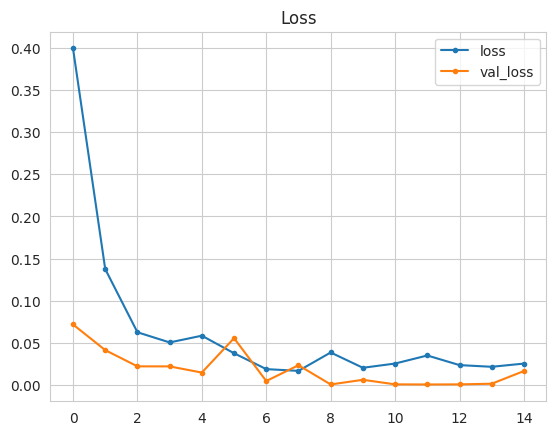

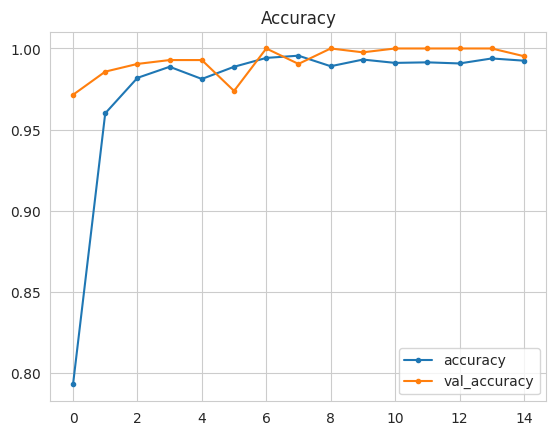

In [30]:
losses = pd.DataFrame(model.history.history)

losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


* #### ROC Curve

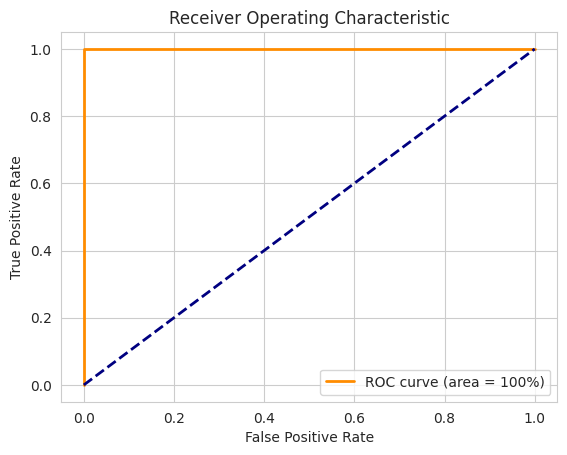

In [39]:
from sklearn.metrics import roc_curve, auc

y_true = test_set.classes
y_pred_probs = model.predict(test_set)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.0f}%)'.format(roc_auc * 100))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(f'{file_path}/roc_curve.png', bbox_inches='tight', dpi=150)
plt.show()

* #### Confusion Matrix

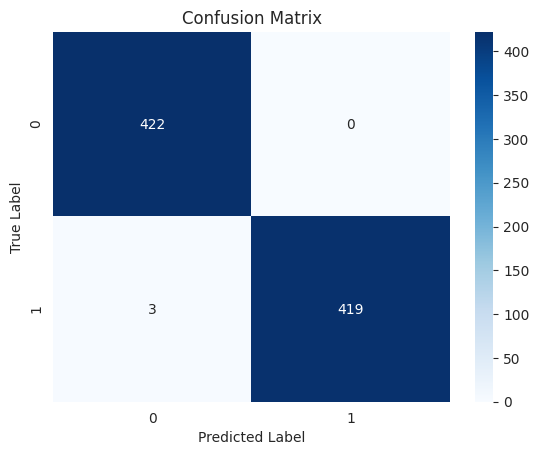

In [41]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = (model.predict(test_set) > 0.5).astype("int32")
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig(f'{file_path}/confusion_matrix.png', bbox_inches='tight', dpi=150)
plt.show()

* #### Classification Report

In [42]:
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       422
           1       1.00      0.99      1.00       422

    accuracy                           1.00       844
   macro avg       1.00      1.00      1.00       844
weighted avg       1.00      1.00      1.00       844



* #### Evaluation model on test set

In [43]:
evaluation = model.evaluate(test_set)
print("Accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Loss: ",evaluation[0])

43/43 [==============================] - 15s 354ms/step - loss: 0.0090 - accuracy: 0.9964
Accuracy: 99.64%
Loss:  0.009038968943059444


* #### Save Evaluation pickle

In [44]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

---